In [1]:
import xarray as xr
import numpy as np
import nc_time_axis

In [2]:
fp = "/Users/keturner/TCRE/ESM4_1pctCO2_D1/gfdl.ncrc4-intel16-prod-openmp/pp/atmos/ts/monthly/5yr"
ds = xr.open_mfdataset(f"{fp}/atmos.*.t_ref.nc", use_cftime=True)

In [37]:
da = ds.t_ref

In [38]:
model, resid = seasonal_model(da)

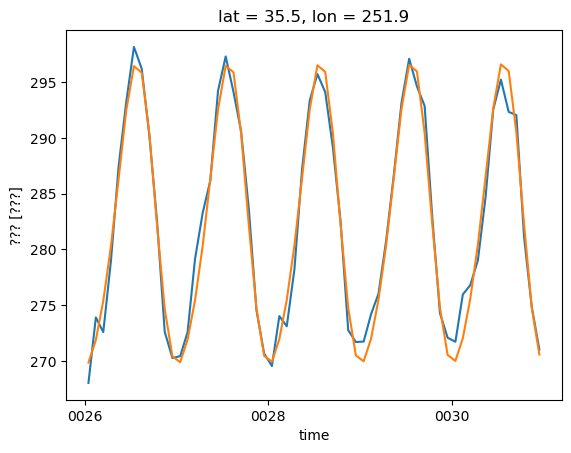

In [41]:
da[300:360, 125, 201].plot()
model[125, 201, 300:360].plot()

In [34]:
def seasonal_model(da_timeseries, tcoord="time"):
    """Function to calculate a seasonal cycle in a time series
    This function creates a modelled time series that includes 
    a linear trend and annual and semi-annual harmonics
    
    f(time) = b + m * time + c1 * sin(2*pi*time/year) + ...
        c2 * cos(2*pi*time/year) + c3 * sin(4*pi*time/year) + ...
        c4 * cos(4*pi*time/year) + residual
    
    Parameters
    ----------
    da_timeseries : xarray.core.dataarray.DataArray
        A time series in a DataArray format, which can be of 
        arbitrary dimensionality
    tcoord : str, optional
        Name of the time coordinate, if present, by default "time"
    Returns
    -------
    seasonal_model : xarray.core.dataarray.DataArray
        Modelled seasonal cycle of time series
    residuals : xarray.core.dataarray.DataArray
        Residuals from modelled fit
    """
    # PREPROCESSING STEP 1
    # Here we want to make sure that all coordinates have non-empty dimensionality.
    # If they are empty we need to drop them
    coords = [x for x in da_timeseries.coords if x != tcoord]
    coords = tuple(coords)

    for i in range(len(coords)):
        if not da_timeseries[f"{coords[i]}"].dims:
            da_timeseries = da_timeseries.drop_vars(f"{coords[i]}")
            
    # PREPROCESSING STEP 2
    # Here we find the non-time coordinates for our dataset and create a hashable 
    # so that the model can be expanded to an arbitrary number of dimensions
    coords = [x for x in da_timeseries.coords if x != tcoord]
    coords = tuple(coords)

    coords_dict = {}
    for i in range(len(coords)):
        coords_dict[coords[i]] = da_timeseries[f"{coords[i]}"]
    hashable_coords = {key: tuple(val.values) for key, val in coords_dict.items()}
    
    
    # From here we use the same code provided by John, extended to multiple dimensions
    time_dec = da_timeseries.time.dt.year + (da_timeseries.time.dt.dayofyear - 1 + da_timeseries.time.dt.hour/24)/365 
    
    model = np.array(
        [np.ones(len(time_dec))]
        + [time_dec - np.mean(time_dec)]
        + [np.sin(2 * np.pi * time_dec)]
        + [np.cos(2 * np.pi * time_dec)]
        + [np.sin(4 * np.pi * time_dec)]
        + [np.cos(4 * np.pi * time_dec)]
        )
    
    pmodel = np.linalg.pinv(model)

    model_da = xr.DataArray(
        model,
        dims=["coeff", "time"],
        coords={"coeff": np.arange(1, 7, 1), "time": da.time},
    )
    model_da = model_da.expand_dims(dim=hashable_coords)

    pmodel_da = xr.DataArray(
        pmodel,
        dims=["time", "coeff"],
        coords={"coeff": np.arange(1, 7, 1), "time": da.time},
    )
    pmodel_da = pmodel_da.expand_dims(dim=hashable_coords)

    mcoeff = pmodel_da.dot(da, dims="time")
    
    seasonal_model = model_da.dot(mcoeff, dims="coeff")
    seasonal_model.attrs = {
        "standard_name": "???",
        "long_name": "???",
        "units": "???",
    }
    
    residuals = da_timeseries - seasonal_model
    residuals.attrs = {
        "standard_name": "???",
        "long_name": "???",
        "units": "???",
    }
    return seasonal_model, residuals